# ARIMA Baseline Model (Endogenous Only)

**Objective**: Build a simple ARIMA model using only historical log returns (no exogenous variables)

**Model**: ARIMA(p, 0, q) where:
- p, q are determined by `pmdarima.auto_arima()`
- d=0 because we model stationary log returns
- No seasonal component (baseline)
- No exogenous variables (pure time series)

**Purpose**: Establish performance benchmark for comparison with SARIMAX and GARCH models

## 1. Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ARIMA modeling
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load and Prepare Data

In [3]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Convert to datetime and set frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df.asfreq('B')  # Business Day frequency

# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
df = df.dropna(subset=['GOLD_LOG_RETURN'])

print(f"Dataset: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nLog Returns Summary:")
print(df['GOLD_LOG_RETURN'].describe())

Dataset: 10525 observations
Date range: 1985-01-03 00:00:00 to 2025-09-10 00:00:00

Log Returns Summary:
count    10525.000000
mean         0.000230
std          0.009755
min         -0.088756
25%         -0.004307
50%          0.000138
75%          0.005005
max          0.104371
Name: GOLD_LOG_RETURN, dtype: float64


## 3. Train-Test Split (Chronological)

**Critical**: Use temporal split, NO shuffle

In [4]:
# 80-20 split
train_size = int(len(df) * 0.8)
train = df['GOLD_LOG_RETURN'].iloc[:train_size]
test = df['GOLD_LOG_RETURN'].iloc[train_size:]

# Store original prices for later transformation
train_prices = df['GOLD_PRICE'].iloc[:train_size]
test_prices = df['GOLD_PRICE'].iloc[train_size:]

print(f"Train set: {len(train)} observations ({train.index.min()} to {train.index.max()})")
print(f"Test set:  {len(test)} observations ({test.index.min()} to {test.index.max()})")
print(f"\nTest set represents {len(test)/len(df)*100:.1f}% of data")

Train set: 8420 observations (1985-01-03 00:00:00 to 2017-07-25 00:00:00)
Test set:  2105 observations (2017-07-26 00:00:00 to 2025-09-10 00:00:00)

Test set represents 20.0% of data


## 4. Model Selection with auto_arima

In [5]:
# Use auto_arima to find optimal (p, q)
print("Running auto_arima... (this may take a few minutes)\n")

auto_model = pm.auto_arima(
    train,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,  # Already stationary (log returns)
    seasonal=False,  # No seasonality in baseline
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True,
    information_criterion='aic'
)

print("\n" + "="*70)
print("OPTIMAL MODEL FOUND")
print("="*70)
print(auto_model.summary())

Running auto_arima... (this may take a few minutes)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-53730.436, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-53730.942, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-53731.010, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-53729.538, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-53730.399, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-53727.140, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-53731.479, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-53730.819, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-53730.024, Time=0.66 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-53730.933, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-53731.410, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-53724.467, Time=0.37 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 3.995 seconds

OPTIMAL MO

In [6]:
# Extract optimal orders
best_order = auto_model.order
print(f"\nBest ARIMA order: {best_order}")
print(f"AIC: {auto_model.aic():.2f}")
print(f"BIC: {auto_model.bic():.2f}")


Best ARIMA order: (0, 0, 1)
AIC: -53731.48
BIC: -53710.36


## 5. Fit Final ARIMA Model

In [7]:
# Fit ARIMA with optimal parameters
model = ARIMA(train, order=best_order)
arima_fit = model.fit()

print("✓ ARIMA model fitted successfully")
print(f"\nModel: ARIMA{best_order}")
print(f"Log-Likelihood: {arima_fit.llf:.2f}")
print(f"AIC: {arima_fit.aic:.2f}")
print(f"BIC: {arima_fit.bic:.2f}")

✓ ARIMA model fitted successfully

Model: ARIMA(0, 0, 1)
Log-Likelihood: 26868.74
AIC: -53731.48
BIC: -53710.37


## 6. Residual Diagnostics

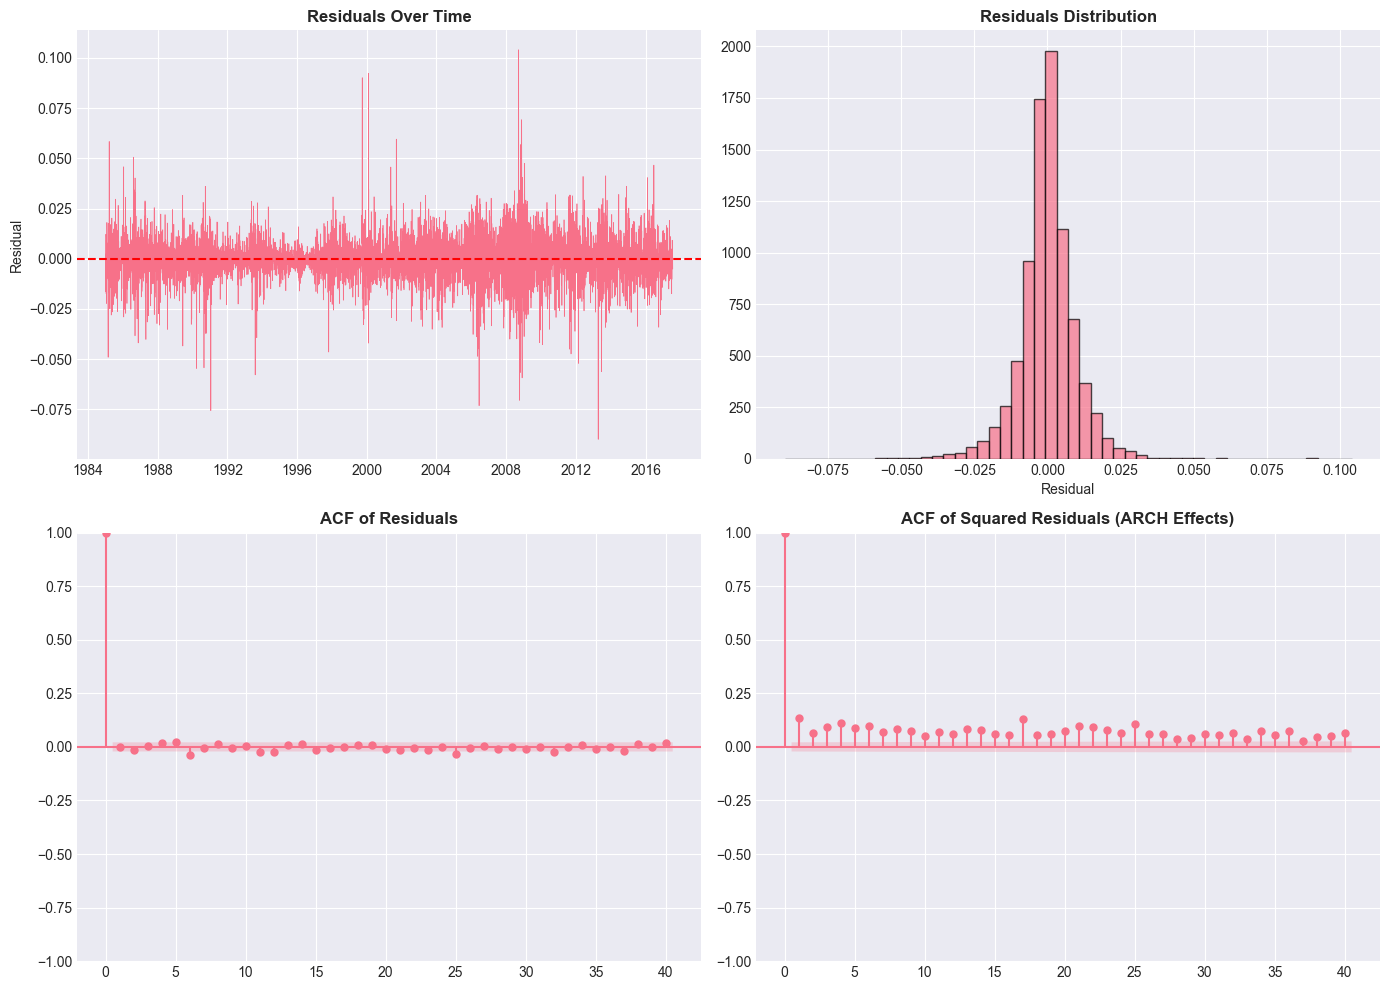

Residuals Mean: 0.000000 (should be ~0)
Residuals Std: 0.009952

⚠ If ACF of squared residuals shows significant lags → ARCH effects present → GARCH needed


In [8]:
# Residuals
residuals = arima_fit.resid

# Plot residuals
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals over time
axes[0, 0].plot(residuals, linewidth=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residual')

# Histogram
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residual')

# ACF
plot_acf(residuals, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontsize=12, fontweight='bold')

# ACF of squared residuals (ARCH test)
plot_acf(residuals**2, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Squared Residuals (ARCH Effects)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Residuals Mean: {residuals.mean():.6f} (should be ~0)")
print(f"Residuals Std: {residuals.std():.6f}")
print(f"\n⚠ If ACF of squared residuals shows significant lags → ARCH effects present → GARCH needed")

## 7. Walk-Forward Validation (5-Day Ahead Forecasts)

**Strategy**: Rolling window with 5-step ahead forecasts

In [9]:
# Walk-forward validation setup
forecast_horizon = 5  # 5 days ahead (one trading week)
predictions_log = []
actuals_log = []
predictions_price = []
actuals_price = []

print("Running walk-forward validation...")
print(f"Forecast horizon: {forecast_horizon} days")
print(f"Test set size: {len(test)}")

# Use expanding window (not rolling)
for i in range(0, len(test) - forecast_horizon, forecast_horizon):
    # Train data: all past observations
    train_data = pd.concat([train, test.iloc[:i]])
    
    # Fit model
    model_temp = ARIMA(train_data, order=best_order)
    fit_temp = model_temp.fit()
    
    # Forecast 5 steps ahead
    forecast_log = fit_temp.forecast(steps=forecast_horizon)
    actual_log = test.iloc[i:i+forecast_horizon]
    
    predictions_log.extend(forecast_log.values)
    actuals_log.extend(actual_log.values)
    
    # Convert log returns to prices
    last_price = df['GOLD_PRICE'].iloc[train_size + i - 1]
    for j in range(len(forecast_log)):
        pred_price = last_price * np.exp(forecast_log.iloc[j])
        actual_price = df['GOLD_PRICE'].iloc[train_size + i + j]
        predictions_price.append(pred_price)
        actuals_price.append(actual_price)
        last_price = pred_price  # Iterative approach

print(f"✓ Generated {len(predictions_price)} forecasts")

Running walk-forward validation...
Forecast horizon: 5 days
Test set size: 2105
✓ Generated 2100 forecasts


## 8. Evaluate Model Performance

In [10]:
# Calculate metrics on PRICES (not log returns)
rmse = np.sqrt(mean_squared_error(actuals_price, predictions_price))
mae = mean_absolute_error(actuals_price, predictions_price)

# Naive benchmark (Random Walk: price_t = price_t-1)
# For 5-day ahead forecast, naive predicts: price_t+5 = price_t
naive_predictions = []
for i in range(0, len(test) - forecast_horizon, forecast_horizon):
    current_price = df['GOLD_PRICE'].iloc[train_size + i - 1]
    for j in range(forecast_horizon):
        naive_predictions.append(current_price)

naive_actuals = actuals_price[:len(naive_predictions)]
naive_predictions = naive_predictions[:len(naive_actuals)]

rmse_naive = np.sqrt(mean_squared_error(naive_actuals, naive_predictions))
mae_naive = mean_absolute_error(naive_actuals, naive_predictions)

print("="*70)
print("MODEL EVALUATION - 5-DAY AHEAD FORECASTS")
print("="*70)
print(f"\nARIMA{best_order} Model:")
print(f"  RMSE: ${rmse:.2f}")
print(f"  MAE:  ${mae:.2f}")
print(f"\nNaive Benchmark (Random Walk):")
print(f"  RMSE: ${rmse_naive:.2f}")
print(f"  MAE:  ${mae_naive:.2f}")
print(f"\nImprovement over Naive:")
print(f"  RMSE: {(1 - rmse/rmse_naive)*100:+.2f}%")
print(f"  MAE:  {(1 - mae/mae_naive)*100:+.2f}%")
print("="*70)

MODEL EVALUATION - 5-DAY AHEAD FORECASTS

ARIMA(0, 0, 1) Model:
  RMSE: $32.62
  MAE:  $21.92

Naive Benchmark (Random Walk):
  RMSE: $32.80
  MAE:  $22.04

Improvement over Naive:
  RMSE: +0.56%
  MAE:  +0.54%


## 9. Visualize Forecasts

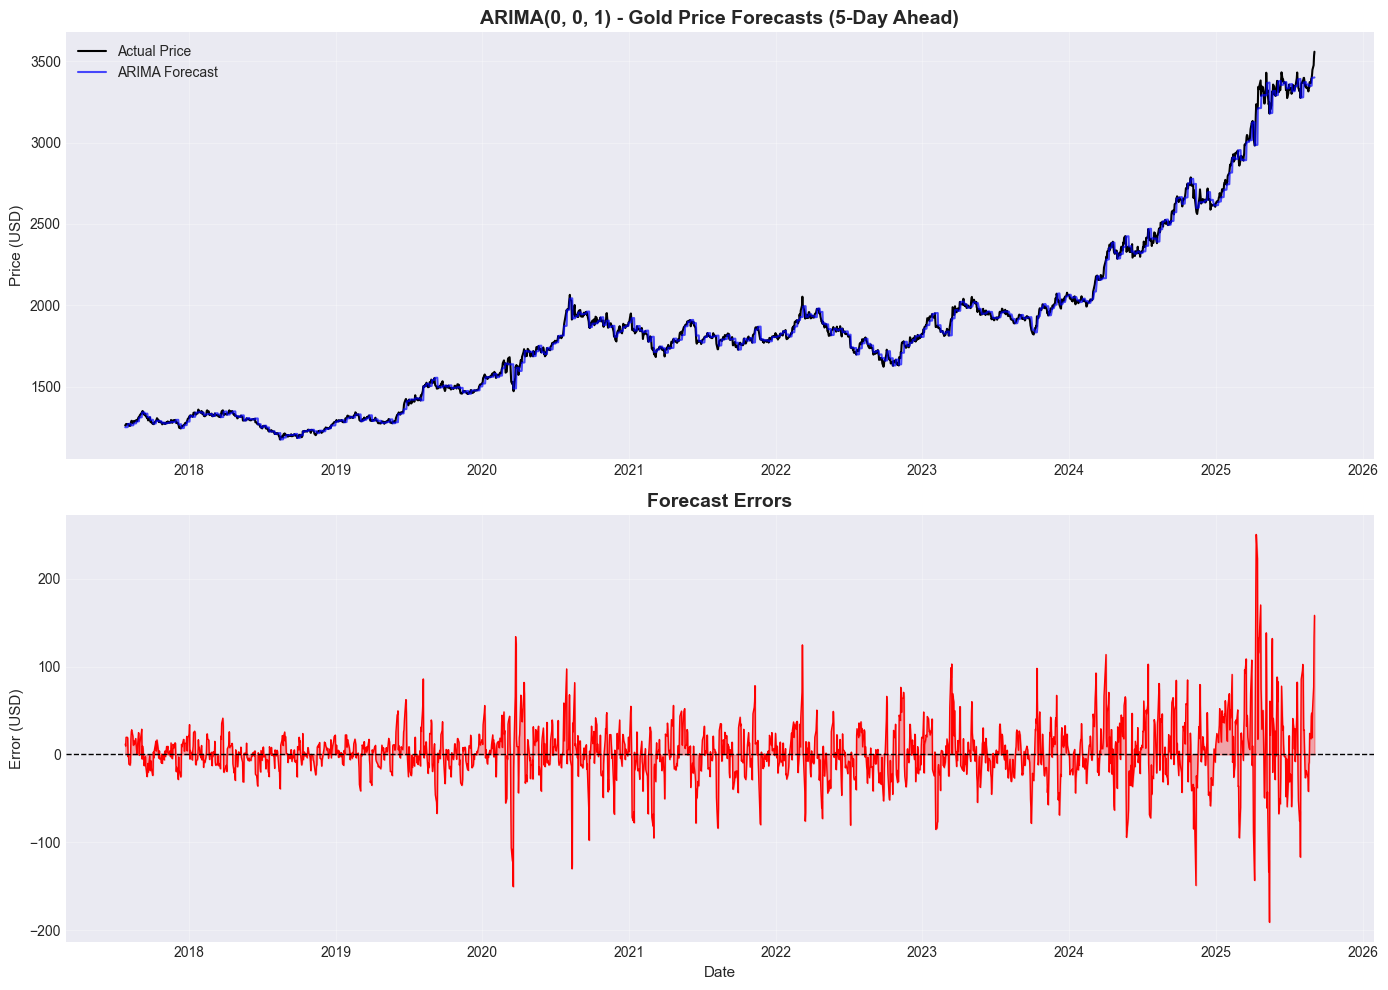

In [11]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price forecasts
forecast_dates = test.index[:len(predictions_price)]
axes[0].plot(forecast_dates, actuals_price, label='Actual Price', color='black', linewidth=1.5)
axes[0].plot(forecast_dates, predictions_price, label='ARIMA Forecast', color='blue', linewidth=1.5, alpha=0.7)
axes[0].set_title(f'ARIMA{best_order} - Gold Price Forecasts (5-Day Ahead)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = np.array(actuals_price) - np.array(predictions_price)
axes[1].plot(forecast_dates, errors, color='red', linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(forecast_dates, errors, 0, alpha=0.3, color='red')
axes[1].set_title('Forecast Errors', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (USD)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Save Model Results

In [12]:
# Create directory for saving results
import os
model_dir = '../models/arima-baseline'
os.makedirs(model_dir, exist_ok=True)

# Save results for comparison
results = {
    'model': f'ARIMA{best_order}',
    'rmse': rmse,
    'mae': mae,
    'rmse_naive': rmse_naive,
    'mae_naive': mae_naive,
    'n_predictions': len(predictions_price)
}

# Save to CSV
results_df = pd.DataFrame([results])
results_df.to_csv(f'{model_dir}/results.csv', index=False)

# Save model
arima_fit.save(f'{model_dir}/model.pkl')

print(f"✓ Model and results saved to '{model_dir}/'")
print("\nFiles created:")
print("  - results.csv")
print("  - model.pkl")

✓ Model and results saved to '../models/arima-baseline/'

Files created:
  - results.csv
  - model.pkl


## 11. Key Findings

**Summary**:
1. ARIMA baseline establishes benchmark performance
2. Check ACF of squared residuals for ARCH effects
3. If present → GARCH extension needed (Notebook 04)
4. Next: Add exogenous variables (SARIMAX, Notebook 03)